# **Functions**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string

In [4]:
def bernoulli_log_pdf(x, mu):
    eps = 1e-10 
    log_prob = x[:, None, :] * np.log(mu[None, :, :] + eps) + \
               (1 - x[:, None, :]) * np.log(1 - mu[None, :, :] + eps)
    return np.sum(log_prob, axis=2)

def em_bernoulli_mixture(X, K=4, max_iter=100):
    N, D = X.shape
    log_likelihoods = []

    np.random.seed()
    pi = np.full(K, 1/K)
    mu = np.random.rand(K, D)

    for iteration in range(max_iter):
        log_prob = bernoulli_log_pdf(X, mu)
        log_prob += np.log(pi + 1e-10)
        log_sum = np.logaddexp.reduce(log_prob, axis=1, keepdims=True)
        log_resp = log_prob - log_sum
        resp = np.exp(log_resp)

        Nk = resp.sum(axis=0)
        pi = Nk / N
        mu = (resp.T @ X) / (Nk[:, None] + 1e-10)

        ll = np.sum(log_sum)
        log_likelihoods.append(ll)

    return pi, mu, log_likelihoods

In [15]:
def gaussian_pdf(x, mean, cov):
    D = len(x)
    det = np.linalg.det(cov)
    inv = np.linalg.inv(cov)
    num = np.exp(-0.5 * (x - mean).T @ inv @ (x - mean))
    den = np.sqrt((2 * np.pi) ** D * det + 1e-10)
    return num / den

In [16]:
def run_em_gmm(X, K, max_iter):
    N, D = X.shape
    np.random.seed()
    means = X[np.random.choice(N, K, replace=False)]
    covs = np.array([np.eye(D) for _ in range(K)])
    pis = np.ones(K) / K

    log_likelihoods = []

    for it in range(max_iter):
        resp = np.zeros((N, K))
        for k in range(K):
            for i in range(N):
                resp[i, k] = pis[k] * gaussian_pdf(X[i], means[k], covs[k])
        resp /= resp.sum(axis=1, keepdims=True) + 1e-10

        Nk = resp.sum(axis=0)
        pis = Nk / N
        for k in range(K):
            means[k] = (resp[:, k].reshape(-1, 1) * X).sum(axis=0) / Nk[k]
            diff = X - means[k]
            covs[k] = (resp[:, k].reshape(-1, 1) * diff).T @ diff / Nk[k]
            covs[k] += np.eye(D) * 1e-6  # regularization

        ll = 0
        for i in range(N):
            tmp = 0
            for k in range(K):
                tmp += pis[k] * gaussian_pdf(X[i], means[k], covs[k])
            ll += np.log(tmp + 1e-10)
        log_likelihoods.append(ll / N)

    return np.array(log_likelihoods)

In [ ]:
def euclidean_distance(row1, row2, feature_cols):
    return sum((row1[col] - row2[col]) ** 2 for col in feature_cols) ** 0.5

# Import

In [25]:
from aquarel import load_theme
import matplotlib.style as mplstyle
mplstyle.core.USER_LIBRARY_PATHS.append('/home/kb/anaconda3/envs/myenv/lib/python3.13/site-packages/aquarel/styles')

In [7]:
df1 = pd.read_csv("A2Q1.csv", header=None)
df2 = pd.read_csv("A2Q2test.csv", header=None)
df2_test = pd.read_csv("A2Q2train.csv", header=None)

In [5]:
df1.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
df1.shape

(400, 50)

In [3]:
df2.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,0.21302,0.446210,0.51432,0.219750,0.49544,0.46367,0.26007,0.28137,0.983820,0.00777,...,0.92910,0.28669,0.45841,0.788740,0.041794,0.58736,0.90491,0.91718,0.68321,2.0121
1,0.32563,0.703990,0.31970,0.045240,0.86968,0.13136,0.47664,0.26632,0.334520,0.81200,...,0.51868,0.25546,0.29498,0.008869,0.169970,0.92325,0.42134,0.90906,0.61539,1.8164
2,0.49539,0.623570,0.58121,0.879160,0.93096,0.20304,0.35752,0.31232,0.066225,0.46389,...,0.85782,0.50530,0.32361,0.693090,0.690430,0.01604,0.46741,0.67303,0.60459,1.6435
3,0.88875,0.013187,0.87982,0.858160,0.79392,0.79239,0.76522,0.85145,0.233610,0.57924,...,0.25535,0.38341,0.55130,0.727730,0.676890,0.84605,0.61116,0.58514,0.41724,2.7451
4,0.15178,0.540760,0.26896,0.006752,0.10102,0.34208,0.86855,0.32698,0.285460,0.80503,...,0.54955,0.12932,0.94848,0.326100,0.268010,0.27125,0.53535,0.91872,0.16801,1.8932


In [4]:
df2_test.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,0.58351,0.37939,0.83975,0.086861,0.61192,0.39203,0.189640,0.585090,0.89494,0.393850,...,0.51706,0.20535,0.829990,0.24995,0.31980,0.19674,0.958550,0.84948,0.92369,1.9741
1,0.86622,0.45135,0.93479,0.235810,0.50488,0.49742,0.117220,0.574880,0.71051,0.336890,...,0.27412,0.46065,0.655440,0.56656,0.49062,0.19920,0.320680,0.41419,0.83023,2.3354
2,0.39142,0.91995,0.13873,0.991810,0.54367,0.98449,0.340260,0.206470,0.40131,0.128990,...,0.27247,0.38911,0.799490,0.57753,0.86682,0.69741,0.628630,0.29479,0.54280,2.2053
3,0.79553,0.27854,0.22890,0.789290,0.49222,0.67084,0.769410,0.057104,0.20393,0.086936,...,0.24901,0.65976,0.943350,0.41246,0.92715,0.11015,0.101310,0.66801,0.34573,2.0400
4,0.65223,0.96665,0.17985,0.354060,0.84042,0.92891,0.014597,0.229530,0.43920,0.548940,...,0.93277,0.23674,0.027077,0.27111,0.23366,0.56356,0.047289,0.62792,0.97930,2.2053


In [5]:
df2.shape

(500, 101)

## **Question1**

## (i)

In [8]:
X = df1.values.astype(np.float64)

In [11]:
max_iter = 50
avg_ll = np.zeros(max_iter)

In [12]:
for run in range(100):
    _, _, ll = em_bernoulli_mixture(X, K=4, max_iter=50)
    avg_ll += np.array(ll)

avg_ll /= 100

In [24]:
plt.style.use('./pitayasmoothie-light.mplstyle')

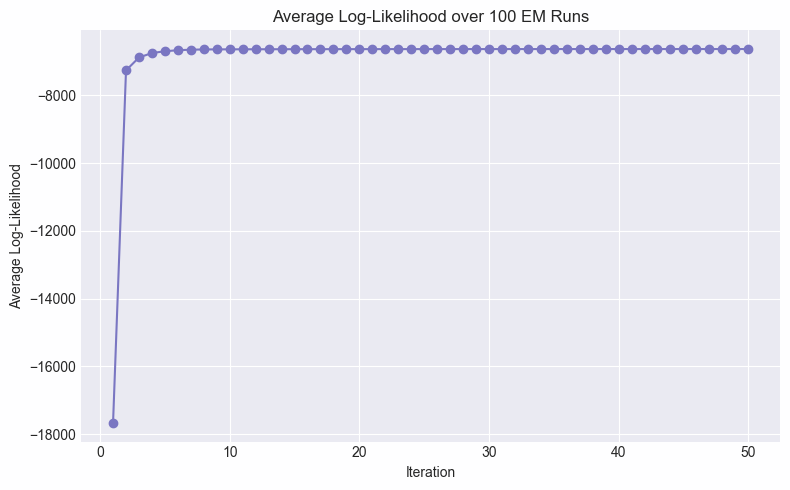

In [25]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, max_iter + 1), avg_ll, marker='o')
plt.title("Average Log-Likelihood over 100 EM Runs")
plt.xlabel("Iteration")
plt.ylabel("Average Log-Likelihood")
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
data = df1.values
N, D = data.shape
K = 4
max_iter = 50
n_init = 100

In [17]:
all_logs = np.zeros((n_init, max_iter))
for r in range(n_init):
    all_logs[r] = run_em_gmm(data, K, max_iter)

avg_log = all_logs.mean(axis=0)

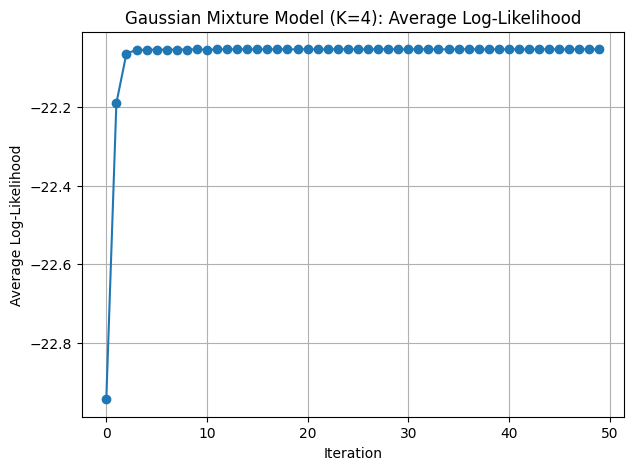

In [18]:
plt.figure(figsize=(7,5))
plt.plot(avg_log, marker='o')
plt.title("Gaussian Mixture Model (K=4): Average Log-Likelihood")
plt.xlabel("Iteration")
plt.ylabel("Average Log-Likelihood")
plt.grid(True)
plt.show()

In [ ]:
def K_means(df, K, plusplus=False):

    errors = []

    df_copy = df.copy()
    feature_cols = [col for col in df.columns]

    if not plusplus:
        centroids = df_copy.sample(n=K).copy()
        centroids['cluster'] = range(1, K + 1)
    else:
        pass

    while True:
        old_cluster_assignments = df_copy['cluster'].copy() if 'cluster' in df_copy else None

        # Assign points to nearest centroid
        clusters = []
        for _, row in df_copy.iterrows():
            min_dist = float('inf')
            assigned_cluster = None
            for _, centroid_row in centroids.iterrows():
                dist = euclidean_distance(row, centroid_row, feature_cols)
                if dist < min_dist:
                    min_dist = dist
                    assigned_cluster = centroid_row['cluster']
            clusters.append(assigned_cluster)

        df_copy['cluster'] = clusters

        # Compute new centroids
        new_centroids = df_copy.groupby('cluster')[feature_cols].mean().reset_index()

        # Compute current iteration error (objective)
        error = 0
        for _, row in df_copy.iterrows():
            centroid_row = new_centroids[new_centroids['cluster'] == row['cluster']].iloc[0]
            error += sum((row[col] - centroid_row[col]) ** 2 for col in feature_cols)
        errors.append(error)

        # Check for convergence
        if old_cluster_assignments is not None and df_copy['cluster'].equals(old_cluster_assignments):
            break

        centroids = new_centroids

    return df_copy, centroids, errors

## **Question2**

The analytical or closed-form solution for the least squares weight vector, $w_{ML}$, is found by solving the normal equation for $w$:

$$
w_{ML} = (X^{T} X)^{-1} X^{T} y
$$

This solution requires the matrix $(X^{T} X)$ to be invertible. If it's not invertible (i.e., it's a singular matrix), a unique analytical solution does not exist.


# CODE

## My Code

In [7]:
class LinReg():
    def __init__(self):
        self.w = None

    def Fit(self,Xo,Y, method = None ,regularize = None, alpha = 0.01, max_iter = 10000, lambda_ = 1, capture_cost = False, tol = 1e-6,  batch_size = 5, epoch = 20):
        X = Xo.copy()
        X.insert(0, "bias", 1)

        X = X.to_numpy()
        Y = Y.to_numpy().reshape(-1, 1)
        m = len(Y)
        
        if method == 'Stoc_GD':
            n = X.shape[1]
            rng = np.random.default_rng()
            self.w = rng.standard_normal((n,1))
            self.w_history = []
            for _ in range(max_iter+1):
                y_pred = X @ self.w
                if capture_cost == True:
                    self.cost = np.sum((Y - y_pred)**2)
                    self.w_history.append(self.w.copy())
                self.diff = (1/m) * ((X.T @ (X @ self.w - Y)))
                self.reg = (lambda_/m) * self.w
                
                if regularize == "Ridge":
                    grad = self.diff + self.reg
                else:
                    grad = self.diff
                self.w = self.w - alpha * grad
                if len(self.w_history) > 1 and np.linalg.norm(self.w_history[-1] - self.w_history[-2]) < tol:
                    break

            if capture_cost == True:
                return self.w, self.w_history
            else:
                return self.w
            
        elif method == 'MiniBatch_GD':
            def List_mean(a):
                avg = sum(a) / len(a)
                return avg

            n = X.shape[1]
            rng = np.random.default_rng()
            self.w = rng.standard_normal((n,1))
            self.w_history = []
            list_ = []

            
            for i in range(0,max_iter+1):
                y_pred = X @ self.w
                if capture_cost == True:
                    self.cost = np.sum((Y - y_pred)**2)
                    self.w_history.append(self.w.copy())
                self.diff = (1/m) * ((X.T @ (X @ self.w - Y)))
                self.reg = (lambda_/m) * self.w
                
                if regularize == "Ridge":
                    grad = self.diff + self.reg
                else:
                    grad = self.diff

                if (i+1)%batch_size != 0:
                    list_.append(grad)
                else:
                    self.w = self.w - alpha * List_mean(list_)
                    list_.clear()

                if len(self.w_history) > 1 and np.linalg.norm(self.w_history[-1] - self.w_history[-2]) < tol:
                    break

            if capture_cost == True:
                return self.w, self.w_history
            else:
                return self.w

        elif method == 'Batch_GD':

            n = X.shape[1]
            rng = np.random.default_rng()
            self.w = rng.standard_normal((n,1))
            self.w_history = []
            list_ = []

            for _ in range(epoch):
                for i in range(0,max_iter+1):
                    y_pred = X @ self.w
                    if capture_cost == True:
                        self.cost = np.sum((Y - y_pred)**2)
                        self.w_history.append(self.w.copy())
                    self.diff = (1/m) * ((X.T @ (X @ self.w - Y)))
                    self.reg = (lambda_/m) * self.w
                    
                    if regularize == "Ridge":
                        grad = self.diff + self.reg
                    else:
                        grad = self.diff

                    list_.append(grad)
                    
                    if len(self.w_history) > 1 and np.linalg.norm(self.w_history[-1] - self.w_history[-2]) < tol:
                        break
                    
                self.w = self.w - alpha * List_mean(list_)

            if capture_cost == True:
                return self.w, self.w_history
            else:
                return self.w
                
        
        else:
            tra = X.T
            if np.linalg.det(tra @ X) == 0:
                raise ValueError("Singular Matrix")
            else:
                self.w = (np.linalg.inv(tra @ X)) @ tra @ Y
                return self.w
            
    def Test(self, X_test):
        if self.w is None:
            raise Exception("Training Not yet Done")
        else:
            X_test = X_test.copy()
            X_test.insert(0, "bias", 1)
            X_test = X_test.to_numpy()
            y_pred = X_test @ self.w
            return y_pred
    
    def Eval(self, Y_Pred, Y_test):
        
        Y_Pred = np.array(Y_Pred).reshape(-1)
        Y_test = np.array(Y_test).reshape(-1)

        meann = np.mean(Y_test)
        ss_res = np.sum((Y_test - Y_Pred)**2)
        ss_tot = np.sum((Y_test - meann)**2)

        R = 1 - (ss_res/ss_tot)
        return R

## My Code 2

In [ ]:
class LinReg():
    def __init__(self):
        self.w = None

    def Fit(self, Xo, Y, method=None, regularize=None, alpha=0.001, max_iter=10000, lambda_=1, capture_cost=False, tol=1e-6, batch_size=100, epoch=20):
        X = Xo.copy()
        X.insert(0, "bias", 1)
        X = X.to_numpy()
        Y = Y.to_numpy().reshape(-1, 1)
        m = len(Y)
        self.w = np.zeros((n, 1))
        self.w_history = []
        n = X.shape[1]

        def List_mean(a):
            return sum(a) / len(a)

        if method == 'Stoc_GD':
            for _ in range(max_iter):
                i = rng.integers(0, m)
                Xi = X[i:i+1]
                Yi = Y[i:i+1]

                y_pred = Xi @ self.w
                if capture_cost:
                    full_pred = X @ self.w
                    self.cost = np.sum((Y - full_pred) ** 2)
                    self.w_history.append(self.w.copy())

                grad = Xi.T @ (Xi @ self.w - Yi)

                if regularize == "Ridge":
                    reg_term = np.zeros_like(self.w)
                    reg_term[1:] = (lambda_ / m) * self.w[1:]
                    grad += reg_term

                self.w -= alpha * grad

                if len(self.w_history) > 1 and np.linalg.norm(self.w_history[-1] - self.w_history[-2]) < tol:
                    break

            return (self.w, self.w_history) if capture_cost else self.w

        elif method == 'MiniBatch_GD':
            for epoch_idx in range(epoch):
                rng = np.random.default_rng()
                indices = rng.permutation(m)
                X_shuffled = X[indices]
                Y_shuffled = Y[indices]

                for start in range(0, m, batch_size):
                    end = start + batch_size
                    Xi = X_shuffled[start:end]
                    Yi = Y_shuffled[start:end]

                    y_pred = Xi @ self.w
                    if capture_cost:
                        full_pred = X @ self.w
                        self.cost = np.sum((Y - full_pred) ** 2)
                        self.w_history.append(self.w.copy())

                    grad = Xi.T @ (Xi @ self.w - Yi) / Xi.shape[0]

                    if regularize == "Ridge":
                        reg_term = np.zeros_like(self.w)
                        reg_term[1:] = (lambda_ / m) * self.w[1:]
                        grad += reg_term

                    self.w -= alpha * grad

                    if len(self.w_history) > 1 and np.linalg.norm(self.w_history[-1] - self.w_history[-2]) < tol:
                        break

            return (self.w, self.w_history) if capture_cost else self.w

        elif method == 'Batch_GD':
            for epoch_idx in range(epoch):
                y_pred = X @ self.w
                if capture_cost:
                    self.cost = np.sum((Y - y_pred) ** 2)
                    self.w_history.append(self.w.copy())

                grad = (X.T @ (X @ self.w - Y)) / m

                if regularize == "Ridge":
                    reg_term = np.zeros_like(self.w)
                    reg_term[1:] = (lambda_ / m) * self.w[1:]
                    grad += reg_term

                self.w -= alpha * grad

                if len(self.w_history) > 1 and np.linalg.norm(self.w_history[-1] - self.w_history[-2]) < tol:
                    break

            return (self.w, self.w_history) if capture_cost else self.w

        else:
            tra = X.T
            try:
                self.w = np.linalg.inv(tra @ X) @ tra @ Y
            except np.linalg.LinAlgError:
                self.w = np.linalg.pinv(tra @ X) @ tra @ Y
            return self.w

    def Test(self, X_test):
        if self.w is None:
            raise Exception("Training Not yet Done")
        X_test = X_test.copy()
        X_test.insert(0, "bias", 1)
        X_test = X_test.to_numpy()
        y_pred = X_test @ self.w
        return y_pred

    def Eval(self, Y_Pred, Y_test):
        R = 0
        Y_Pred = np.array(Y_Pred).reshape(-1)
        Y_test = np.array(Y_test).reshape(-1)
        y_mean = np.mean(Y_test)
        ss_res = np.sum((Y_test - Y_Pred) ** 2)
        ss_tot = np.sum((Y_test - y_mean) ** 2)
        R = 1 - (ss_res / ss_tot)
        return R

In [33]:
import numpy as np
import pandas as pd

class LinReg():
    def __init__(self):
        self.w = None
        self.w_history = []
        self.cost = None

    def Fit(self, Xo, Y, method=None, regularize=None, alpha=0.001, max_iter=10000, lambda_=1, capture_cost=False, tol=1e-6, batch_size=100, epoch=20):
        X = Xo.copy()
        X.insert(0, "bias", 1)
        X = X.to_numpy()
        Y = Y.to_numpy().reshape(-1, 1)
        m, n = X.shape

        self.w = np.zeros((n, 1))
        self.w_history = []

        rng = np.random.default_rng()

        def List_mean(a):
            return sum(a) / len(a)

        # ---------------- Stochastic Gradient Descent ----------------
        if method == 'Stoc_GD':
            for _ in range(max_iter):
                i = rng.integers(0, m)
                Xi = X[i:i+1]
                Yi = Y[i:i+1]

                grad = Xi.T @ (Xi @ self.w - Yi)

                if regularize == "Ridge":
                    reg_term = np.zeros_like(self.w)
                    reg_term[1:] = (lambda_ / m) * self.w[1:]
                    grad += reg_term

                self.w -= alpha * grad

                if capture_cost:
                    full_pred = X @ self.w
                    self.cost = np.sum((Y - full_pred) ** 2)
                    self.w_history.append(self.w.copy())

                if len(self.w_history) > 1 and np.linalg.norm(self.w_history[-1] - self.w_history[-2]) < tol:
                    break

            return (self.w, self.w_history) if capture_cost else self.w

        # ---------------- Mini-Batch Gradient Descent ----------------
        elif method == 'MiniBatch_GD':
            for epoch_idx in range(epoch):
                indices = rng.permutation(m)
                X_shuffled = X[indices]
                Y_shuffled = Y[indices]

                for start in range(0, m, batch_size):
                    end = start + batch_size
                    Xi = X_shuffled[start:end]
                    Yi = Y_shuffled[start:end]

                    grad = Xi.T @ (Xi @ self.w - Yi) / Xi.shape[0]

                    if regularize == "Ridge":
                        reg_term = np.zeros_like(self.w)
                        reg_term[1:] = (lambda_ / m) * self.w[1:]
                        grad += reg_term

                    self.w -= alpha * grad

                    if capture_cost:
                        full_pred = X @ self.w
                        self.cost = np.sum((Y - full_pred) ** 2)
                        self.w_history.append(self.w.copy())

                    if len(self.w_history) > 1 and np.linalg.norm(self.w_history[-1] - self.w_history[-2]) < tol:
                        break

            return (self.w, self.w_history) if capture_cost else self.w

        # ---------------- Batch Gradient Descent ----------------
        elif method == 'Batch_GD':
            for epoch_idx in range(epoch):
                grad = (X.T @ (X @ self.w - Y)) / m

                if regularize == "Ridge":
                    reg_term = np.zeros_like(self.w)
                    reg_term[1:] = (lambda_ / m) * self.w[1:]
                    grad += reg_term

                self.w -= alpha * grad

                if capture_cost:
                    full_pred = X @ self.w
                    self.cost = np.sum((Y - full_pred) ** 2)
                    self.w_history.append(self.w.copy())

                if len(self.w_history) > 1 and np.linalg.norm(self.w_history[-1] - self.w_history[-2]) < tol:
                    break

            return (self.w, self.w_history) if capture_cost else self.w

        # ---------------- Closed-form Solution ----------------
        else:
            tra = X.T
            try:
                self.w = np.linalg.inv(tra @ X) @ tra @ Y
            except np.linalg.LinAlgError:
                self.w = np.linalg.pinv(tra @ X) @ tra @ Y
            return self.w

    # ---------------- Prediction ----------------
    def Test(self, X_test):
        if self.w is None:
            raise Exception("Training Not yet Done")
        X_test = X_test.copy()
        X_test.insert(0, "bias", 1)
        X_test = X_test.to_numpy()
        y_pred = X_test @ self.w
        return y_pred

    # ---------------- R^2 Evaluation ----------------
    def Eval(self, Y_Pred, Y_test):
        Y_Pred = np.array(Y_Pred).reshape(-1)
        Y_test = np.array(Y_test).reshape(-1)
        y_mean = np.mean(Y_test)
        ss_res = np.sum((Y_test - Y_Pred) ** 2)
        ss_tot = np.sum((Y_test - y_mean) ** 2)
        R = 1 - (ss_res / ss_tot)
        return R


In [14]:
_, _, e = K_means(df1, 4)

In [28]:
plt.style.use('./rose-pine-moon.mplstyle')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']

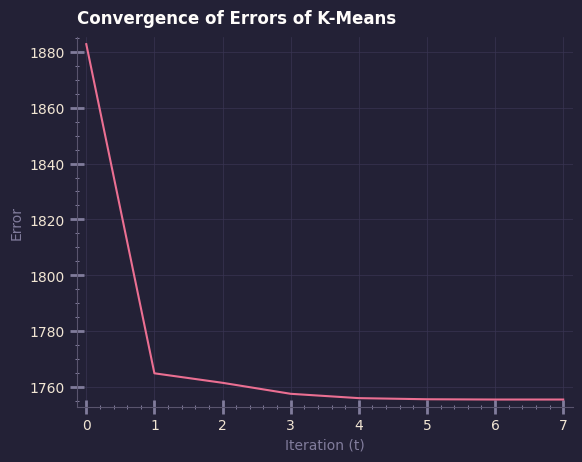

In [29]:
plt.plot(e)
plt.xlabel("Iteration (t)")
plt.ylabel("Error")
plt.title("Convergence of Errors of K-Means")
plt.grid(True)
plt.show()

## Question 2

In [34]:
X_train = df2.iloc[:, 0:100]
Y_train = df2.iloc[:, 100]
X_test = df2_test.iloc[:, 0:100]
Y_test = df2_test.iloc[:, 100]

**i. Obtain the least squares solution wML to the regression problem using the analytical solution.**

In [35]:
ModelA = LinReg()
w_A = ModelA.Fit(X_train,Y_train)
y_hat_A = ModelA.Test(X_test)
Rsq_A = ModelA.Eval(y_hat_A, Y_test)
print(Rsq_A)

-0.5994543894485629


In [36]:

X_train_std = (X_train - X_train.mean()) / X_train.std()
X_test_std = (X_test - X_train.mean()) / X_train.std()

**ii. Code the gradient descent algorithm with suitable step size to solve the least squares algorithms and plot ∥wt − wML∥2 as a function of t. What do you observe?**

In [37]:
ModelB = LinReg()
w_B, res_B = ModelB.Fit(X_train, Y_train, alpha=0.001, epoch=100000, method = 'Batch_GD', capture_cost = True)
y_hat_B = ModelB.Test(X_test)
Rsq_B = ModelB.Eval(y_hat_B, Y_test)
print(Rsq_B)

-0.5859338588117458


In [38]:
norm = []
for wi in res_B:
    norm.append(np.linalg.norm(w_B - wi))

In [39]:
plt.style.use('./pitayasmoothie-dark.mplstyle')

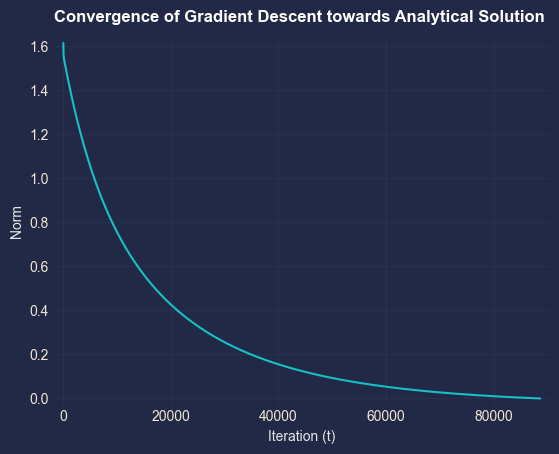

In [40]:
plt.plot(norm)
plt.xlabel("Iteration (t)")
plt.ylabel("Norm")
plt.title("Convergence of Gradient Descent towards Analytical Solution")
plt.grid(True)
plt.show()

**iii. Code the stochastic gradient descent algorithm using batch size of 100 and plot ∥wt −wML∥2 as a function of t. What are your observations?**

In [41]:
ModelC = LinReg()
w_C, res_C = ModelC.Fit(X_train, Y_train, alpha=0.001, epoch=100000, method = 'MiniBatch_GD', capture_cost = True, batch_size=100)
y_hat_C = ModelC.Test(X_test)
Rsq_C = ModelC.Eval(y_hat_C, Y_test)
print(Rsq_C)

-0.5995226503489923


In [42]:
norm = []
for wi in res_C:
    norm.append(np.linalg.norm(w_C - wi))

In [43]:
plt.style.use('./pitayasmoothie-dark.mplstyle')

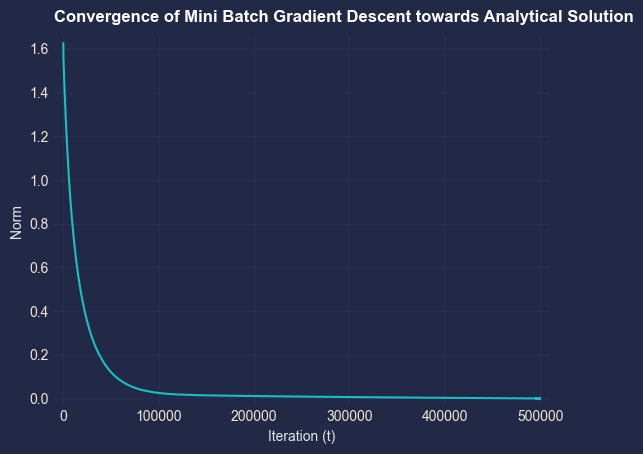

In [44]:
plt.plot(norm)
plt.xlabel("Iteration (t)")
plt.ylabel("Norm")
plt.title("Convergence of Mini Batch Gradient Descent towards Analytical Solution")
plt.grid(True)
plt.show()

In [ ]:
'''ModelD = LinReg()
lambdaZ = [0, 0.001, 0.01, 0.1, 1, 10, 100]
for i in lambdaZ:
    w_D, res_D = ModelC.Fit(X_train, Y_train, alpha=0.001, epoch=100000,regularize='Ridge', method = 'Batch_GD', capture_cost = True, lambda_=i)
y_hat_D = ModelD.Test(X_test)
Rsq_D = ModelD.Eval(y_hat_D, Y_test)
print(Rsq_D)'''

TypeError: range expected at least 1 argument, got 0

In [18]:
import numpy as np
import pandas as pd

# ---------- Utility functions ----------
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

# ---------- Ridge Regression using Gradient Descent ----------
def ridge_gd(X, y, alpha=0.001, lambda_=0.1, epochs=10000):
    N, d = X.shape
    w = np.zeros((d,1))
    for _ in range(epochs):
        y_pred = X @ w
        grad = (1/N) * (X.T @ (y_pred - y)) + lambda_ * w
        w -= alpha * grad
    return w

# ---------- k-Fold Cross-validation ----------
def cross_validate(X, y, lambdas, k=5, alpha=0.001, epochs=10000):
    N = X.shape[0]
    fold_size = N // k
    errors = []

    for lambda_ in lambdas:
        fold_errors = []
        for i in range(k):
            start, end = i*fold_size, (i+1)*fold_size
            X_val, y_val = X[start:end], y[start:end]
            X_train = np.vstack((X[:start], X[end:]))
            y_train = np.vstack((y[:start], y[end:]))

            w = ridge_gd(X_train, y_train, alpha=alpha, lambda_=lambda_, epochs=epochs)
            y_pred = X_val @ w
            fold_errors.append(mse(y_val, y_pred))
        errors.append(np.mean(fold_errors))
    return errors

In [20]:
# ---------- Load data ----------
train = pd.read_csv("A2Q2train.csv")
test = pd.read_csv("A2Q2test.csv")

X_train = train.iloc[:,:-1].to_numpy()
y_train = train.iloc[:,-1].to_numpy().reshape(-1,1)
X_test = test.iloc[:,:-1].to_numpy()
y_test = test.iloc[:,-1].to_numpy().reshape(-1,1)

# Add bias
X_train = np.hstack((np.ones((X_train.shape[0],1)), X_train))
X_test = np.hstack((np.ones((X_test.shape[0],1)), X_test))

# ---------- Cross-validate ----------
lambdas = [0, 0.001, 0.01, 0.1, 1, 10, 100]
errors = cross_validate(X_train, y_train, lambdas, k=5, alpha=0.001, epochs=5000)

# ---------- Pick best lambda ----------
best_lambda = lambdas[np.argmin(errors)]
print("Best λ:", best_lambda)

# ---------- Train final Ridge model ----------
wR = ridge_gd(X_train, y_train, alpha=0.001, lambda_=best_lambda, epochs=20000)

# ---------- Compare with closed-form Ridge (wML) ----------
wML = np.linalg.inv(X_train.T @ X_train + best_lambda * np.eye(X_train.shape[1])) @ X_train.T @ y_train

# ---------- Test MSE ----------
mse_R = mse(y_test, X_test @ wR)
mse_ML = mse(y_test, X_test @ wML)

print("Test MSE (Gradient Descent Ridge):", mse_R)
print("Test MSE (Closed-form Ridge):", mse_ML)

Best λ: 0
Test MSE (Gradient Descent Ridge): 0.31164052963593664
Test MSE (Closed-form Ridge): 0.37147765601229843


In [23]:
theme = load_theme("umbra_dark")
theme.apply()
theme.apply_transforms()

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']

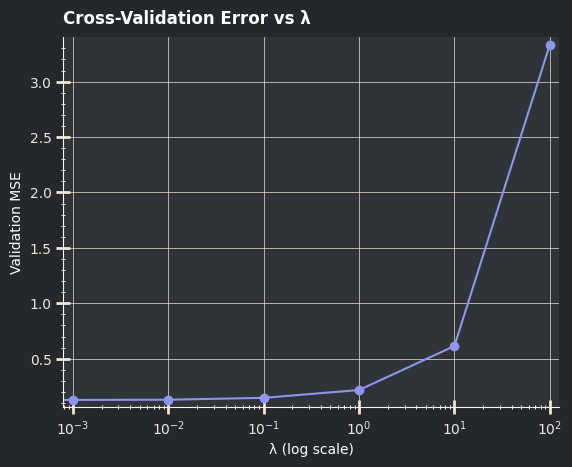

In [24]:
plt.plot(lambdas, errors, marker='o')
plt.xscale('log')
plt.xlabel('λ (log scale)')
plt.ylabel('Validation MSE')
plt.title('Cross-Validation Error vs λ')
plt.show()
